In [ ]:
%reset-f

In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1644935302746125088
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8132177952996606606
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [1]:
!pip install matplotlib==3.5.1
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [2]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

In [3]:
ims=[tiff.imread("gdrive/MyDrive/Biphoton/5-5_1024-1024_5s_0_0.lsm"),
     tiff.imread("gdrive/MyDrive/Biphoton/NDD_5-5_1024-1024_5s_0_0.lsm"),
     tiff.imread("gdrive/MyDrive/Biphoton/interne_5-5_1024-1024_5s_1_1.lsm"),
     tiff.imread("gdrive/MyDrive/Biphoton/NDD_5-5_1024-1024_5s_1_1.lsm")]

In [4]:

def untile(im):
    nim=[]
    for i in range(5):
        for j in range(5):
            nim.append(im[:,:,(j)*1024:(j+1)*1024,(i)*1024:(i+1)*1024])
    return nim

def selmax(im):
    nim=np.zeros((25,2,1024,1024))
    num=0
    for i in im:
        nim[num]=i[0]
        for j in i:
            if np.mean(j[0])>np.mean(nim[num][0]):
                nim[num]=j
        num+=1
    return np.transpose(nim,(0,2,3,1))
imgs=None
for im in ims:
    im2=untile(im)
    im3=selmax(im2)
    if imgs is None:
        imgs=im3
    else:imgs=np.concatenate((imgs,im3),axis=0)
img0=np.expand_dims(imgs[...,0],axis=3)
img1=np.expand_dims(imgs[...,1],axis=3)
imgs=np.concatenate((img0,img1),axis=0)
print(np.shape(imgs))

(200, 1024, 1024, 1)


In [5]:
"""
plt.figure(figsize=(15,30))
for i in range(10):
    for j in range(5):
        ax = plt.subplot(10, 5, i*5+j+1)
        ax.axis("off")
        plt.imshow(img[i*5+j,:,:,0])
"""
None

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class Tile:
    '''
    Usage    : Tile(image,tilesize,overlap,verbose)
    image    : Array of shape [length,width,canals]
    tilesize : The output will be of shape [tilesize,tilesize,canals]
    overlap  : Amount of pixel common between two consecutive tiles
    ================================================================
    Methods  :
    padding(mode="reflect"): Returns a padded image via numpy.pad usage
    tilegeneration()       : Returns a list parts of original image(tiles)
    tilevis(concat=True)   : Plots the tiles list for the image
    detmask()              : Returns the mask of overlapping areas
    reconstruct()          : Builds the image back out of the tile list   
    '''
    
    def __init__(self, image, tilesize=None,overlap=None,verbose=False):
        
        self.im = image
        self.s  = np.shape(self.im)[:2]
        if tilesize is None:tilesize=self.s[0]//4
        self.t  = tilesize
        if overlap is None :overlap =tilesize//4
        self.o  = overlap
        self.verbose=verbose
        self.verdata()
        self.to = self.t-self.o
        self.nbt= [(self.s[0]-self.o)//self.to+1,(self.s[1]-self.o)//self.to+1]
        self.p  = None
        self.pIm= None
        self.tl = None
        
    def verdata(self):
        if (np.shape(self.im)[0]%2)!=0:
            if self.verbose:print("Changing image to an even dimension value, one pixel was removed on axis zero.")
            self.im=self.im[:-1]
        if (np.shape(self.im)[1]%2)!=0:
            if self.verbose:print("Changing image to an even dimension value, one pixel was removed on axis one.")
            self.im=self.im[:,:-1]
        if self.o%2!=0:
            if self.verbose:print("Please use even value for overlap, overlap was reduced by one.")
            self.o-=1
        if self.t>np.shape(self.im)[0] or self.t>np.shape(self.im)[1]:
            if self.verbose:print("You probably didn't do what you want, you will just have one padded image. (Tile size larger than image)")
                      
    def detpad(self):
        psize=[(self.nbt[0]*self.to+self.o)-self.s[0],(self.nbt[1]*self.to+self.o)-self.s[1]]
        for i in range(len(psize)):
            if  psize[i]==self.to:
                psize[i]%=self.to
                self.nbt[i]-=1
        return psize
    
    def padding(self,mode="reflect"):
        if self.p is None:
            self.p=self.detpad()
        padval=int(self.p[0]/2),int(self.p[1]/2)
        pIm=np.pad(self.im,((padval[0],padval[0]),(padval[1],padval[1]),(0,0)),mode=mode)
        return pIm
    
    def tilegeneration(self):
        if self.pIm is None:
            self.pIm=self.padding()
        tiles=[]
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                tiles.append(self.pIm[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t])
        return tiles
    
    def tilevis(self,concat=True):
        if self.tl is None:
            self.tl=self.tilegeneration()
        plt.figure(figsize =( 3*self.nbt[1], 3*self.nbt[0]))
        if not concat:
            for i in range(self.nbt[0]):
                for j in range(self.nbt[1]):
                    ax = plt.subplot(self.nbt[0], self.nbt[1], i*self.nbt[1]+j+1)
                    ax.axis("off")
                    plt.imshow(self.tl[i*self.nbt[1]+j])
        else:
            im=[]
            for i in range(self.nbt[0]):
                line=[]
                for j in range(self.nbt[1]):
                    if j==0: line=self.tl[i*self.nbt[1]+j]
                    else: line = np.concatenate((line,self.tl[i*self.nbt[1]+j]),axis=1)
                if i==0:im=line
                else:im=np.concatenate((im,line),axis=0)
            plt.imshow(im)
        plt.show()
        
    
    def detmask(self):
        if self.pIm is None:
            self.pIm=self.padding()
        mask=np.zeros(np.shape(self.pIm)[:2])
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                mask[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t]+=np.ones((self.t,self.t))
        return mask[int(self.p[0]/2):self.s[0]+int(self.p[0]/2),int(self.p[1]/2):self.s[1]+int(self.p[1]/2)]
    
    def reconstruct(self,tl=None):
        if self.tl is None:
            self.tl=self.tilegeneration()
        reim=np.zeros(np.shape(self.pIm))
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                reim[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t]+=self.tl[i*self.nbt[1]+j]
        reim=reim[int(self.p[0]/2):self.s[0]+int(self.p[0]/2),int(self.p[1]/2):self.s[1]+int(self.p[1]/2)]
        mask=self.detmask()
        for i in range(np.shape(reim)[2]):
            reim[...,i]/=mask
        return reim.astype(int)


In [7]:
def tiling(dataset,tilesize=256,overlap=64):
    tiled=[]
    for i in dataset:
        tempi=Tile(i,tilesize,overlap)
        tiled.append(tempi.tilegeneration())
    return np.reshape(tiled,(-1,tilesize,tilesize,np.shape(dataset)[-1]))
tilesize=256
overlap=64
print(np.shape(imgs))
spl=int(len(imgs)*.8)
x_train=tiling(imgs[:spl],tilesize,overlap)
x_test=tiling(imgs[spl:],tilesize,overlap)
print(np.shape(x_train),np.shape(x_test))

(200, 1024, 1024, 1)
(4000, 256, 256, 1) (1000, 256, 256, 1)


In [8]:
import gc
del imgs
gc.collect()

67

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
from keras import activations
latent_dim = 200

In [12]:
encoder_inputs = keras.Input(shape=(np.shape(x_train)[-3:]))
x = layers.Conv2D(16, 3, strides=1, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2D(16, 3, strides=1, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2D(32, 3, strides=1, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2D(128, 3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2D(256, 3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Flatten()(x)
x = layers.Dense(400)(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 256, 256, 32  128        ['conv2d_2[0][0]']               
 rmalization)                   )                                                           

In [13]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 256)(latent_inputs)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Reshape((8, 8, 256))(x)
x = layers.Conv2DTranspose(256, 3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2DTranspose(128, 3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2DTranspose(16, 3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
x = layers.Conv2DTranspose(16, 3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = activations.swish(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 16384)             3293184   
                                                                 
 batch_normalization_11 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 tf.nn.silu_11 (TFOpLambda)  (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                   

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [15]:
print(np.unique(x_train[0]))

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.
  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.
 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113.
 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127.
 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141.
 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155.
 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169.
 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183.
 184. 186. 187. 188. 189. 190. 191. 192. 193. 195. 196. 197. 198. 199.
 200. 

In [16]:
if np.max(x_train)>1:x_train=x_train.astype("float32") / 255

es_callback=tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,)

x_train=np.random.permutation(x_train)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
h1=vae.fit(x_train, epochs=100, batch_size=64,callbacks=es_callback)

In [21]:
import pickle
if True :
  with open('/content/gdrive/MyDrive/Biphoton/objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
      pickle.dump([vae.encoder,vae.decoder], f)

if False :
  with open('/content/gdrive/MyDrive/Biphoton/objs.pkl','rb') as f:  # Python 3: open(..., 'rb')
      vae.encoder,vae.decoder = pickle.load(f)

INFO:tensorflow:Assets written to: ram://9b142493-a8ed-41d6-9d90-9537c5c374c9/assets
INFO:tensorflow:Assets written to: ram://6eb58e56-d6cf-4426-bbc3-f82c5f490878/assets


In [21]:
es_callback=tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=15,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,)
x_train=np.random.permutation(x_train)
#vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
h2=vae.fit(x_train, epochs=50, batch_size=48,callbacks=es_callback)

Epoch 1/50
11/84 [==>...........................] - ETA: 1:04 - loss: nan - reconstruction_loss: nan - kl_loss: nan

KeyboardInterrupt: ignored

In [25]:
import gc
gc.collect()

12637

In [18]:
es_callback=tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,)
x_train=np.random.permutation(x_train)
#vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
h2=vae.fit(x_train, epochs=100, batch_size=64,callbacks=es_callback)


Epoch 1/100
63/63 [==============================] - 132s 2s/step - loss: 4721.2665 - reconstruction_loss: 4379.8145 - kl_loss: 143.0895
Epoch 2/100
63/63 [==============================] - 109s 2s/step - loss: 4318.5597 - reconstruction_loss: 4213.8325 - kl_loss: 144.4736
Epoch 3/100
63/63 [==============================] - 108s 2s/step - loss: 4415.4285 - reconstruction_loss: 4199.2090 - kl_loss: 143.6311
Epoch 4/100
63/63 [==============================] - 109s 2s/step - loss: 4350.8939 - reconstruction_loss: 4209.8550 - kl_loss: 143.9841
Epoch 5/100
63/63 [==============================] - 109s 2s/step - loss: 4399.0750 - reconstruction_loss: 4202.3423 - kl_loss: 142.5223
Epoch 6/100
63/63 [==============================] - 109s 2s/step - loss: 4338.1713 - reconstruction_loss: 4206.6787 - kl_loss: 142.7304
Epoch 7/100
63/63 [==============================] - 108s 2s/step - loss: 4339.5320 - reconstruction_loss: 4198.8784 - kl_loss: 141.9935
Epoch 8/100
63/63 [======================

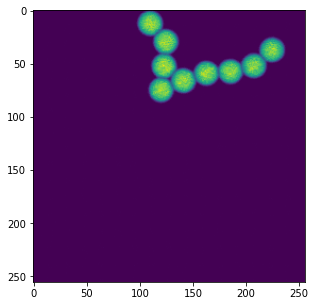

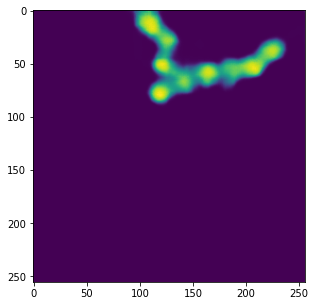

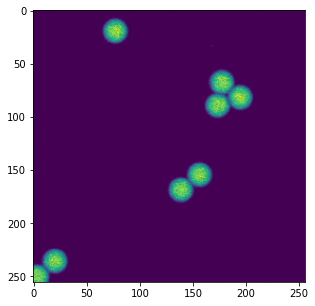

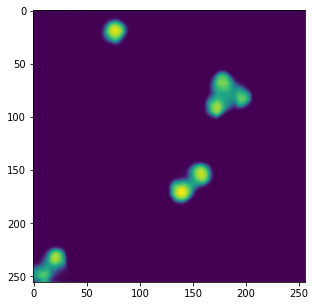

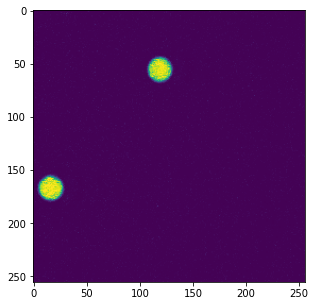

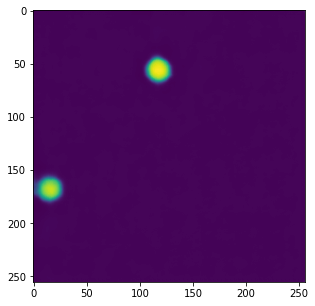

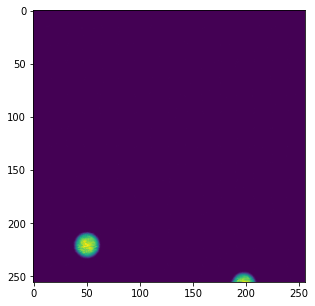

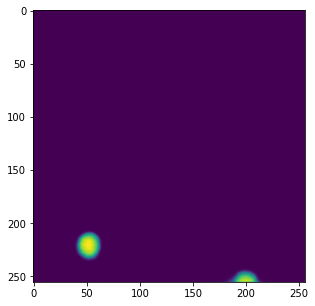

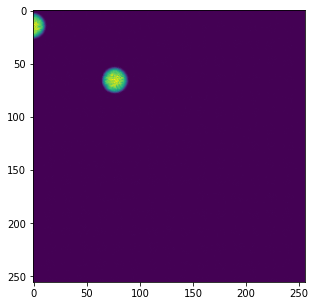

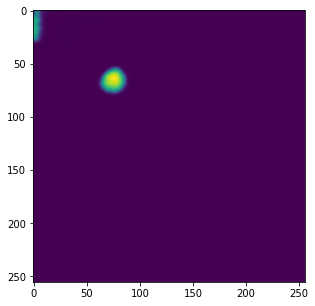

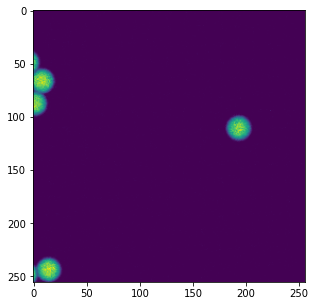

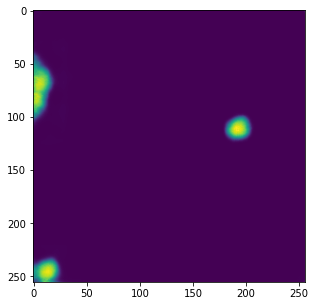

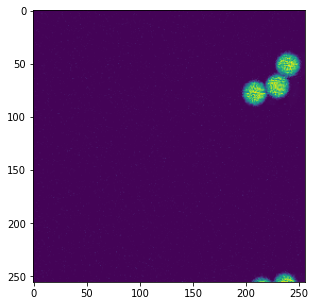

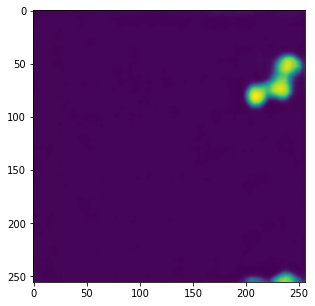

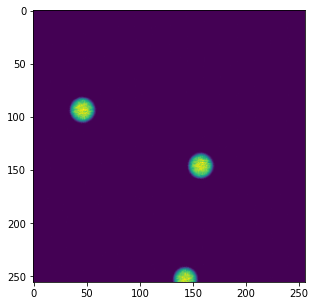

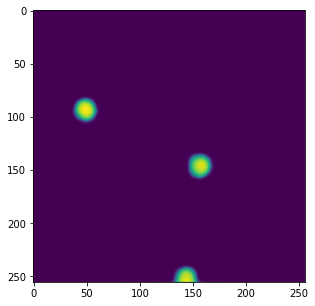

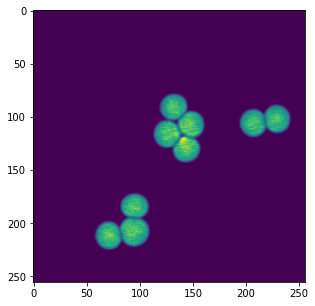

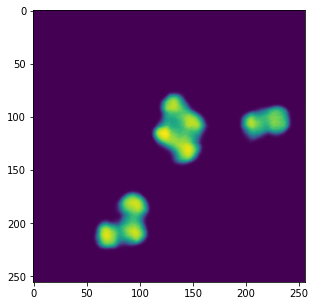

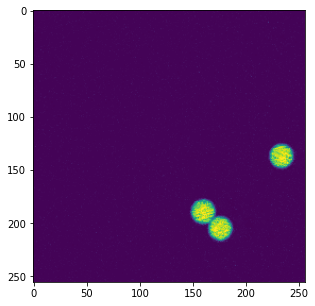

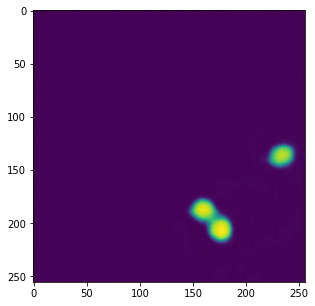

In [19]:
from PIL import Image
for i in range(len(x_train[:5])):
  x=np.array(((vae.decoder.predict(vae.encoder.predict(np.expand_dims(x_train[i],axis=0))[2]))*255).astype("uint8").squeeze())
  im=Image.fromarray(x)
  im.save("gdrive/MyDrive/Biphoton/saves/img%d.png"%i)
  del x,im

for i in range(10):
  xpred=vae.encoder.predict(np.expand_dims(x_train[i],axis=0))
  x_pred=vae.decoder.predict(xpred[2])
  plt.figure(figsize=(5,5))
  plt.imshow(x_train[i,...,0])
  plt.figure(figsize=(5,5))
  plt.imshow(x_pred[0])

In [49]:
pic=cv2.imread("gdrive/MyDrive/Biphoton/saves/img0.png")
print(pic)

None


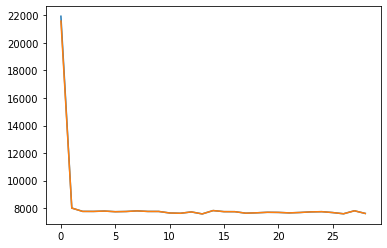

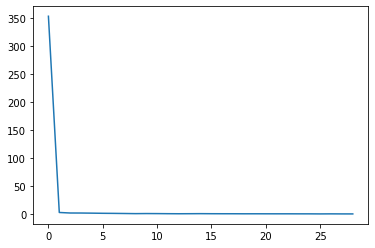

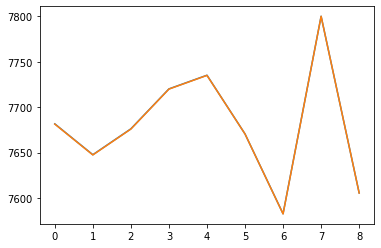

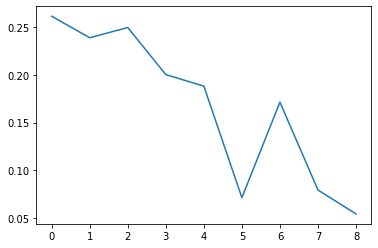

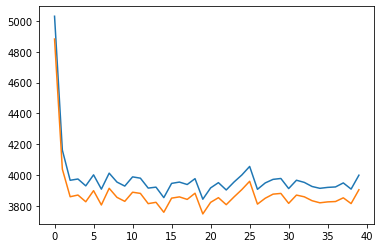

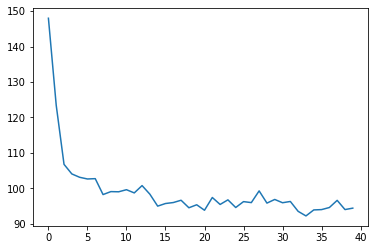

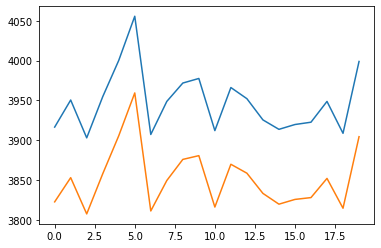

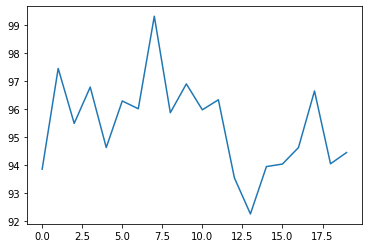

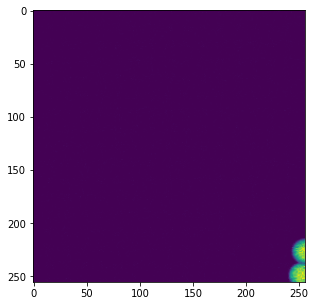

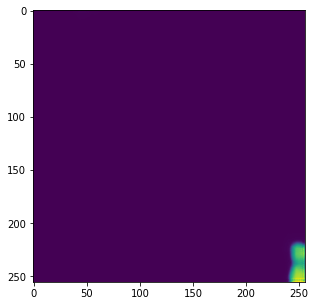

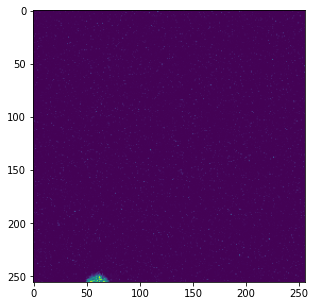

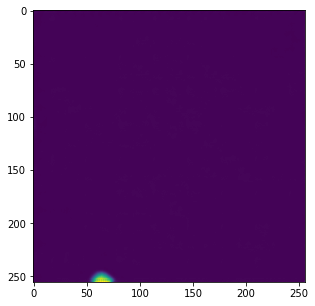

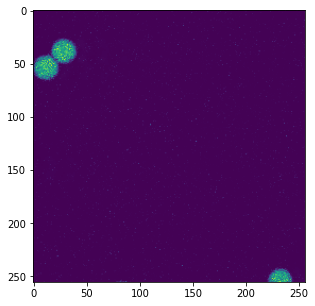

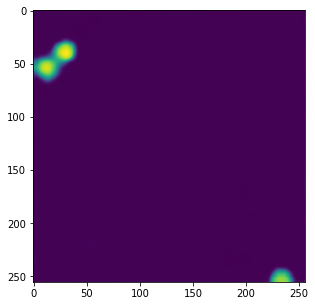

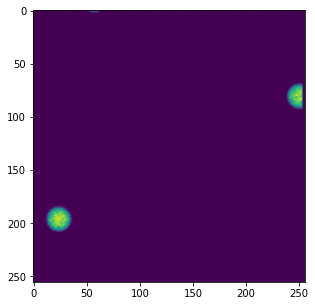

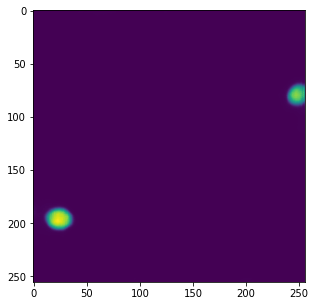

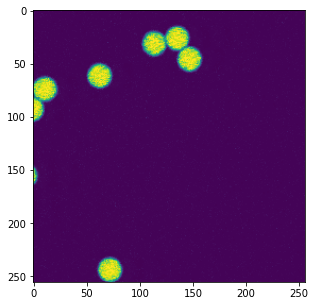

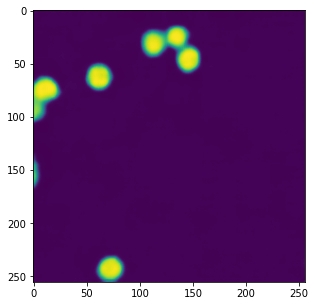

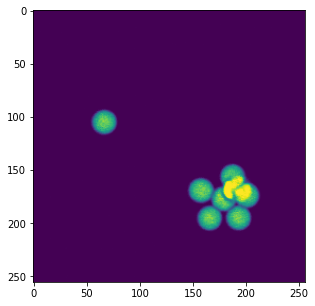

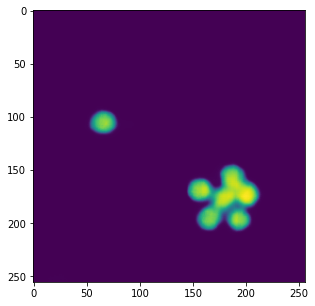

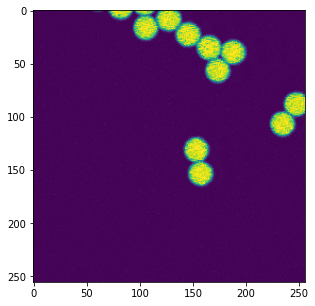

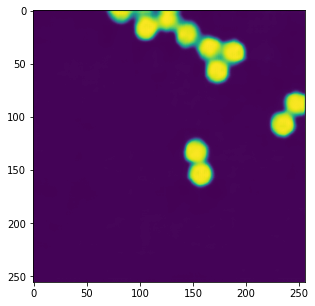

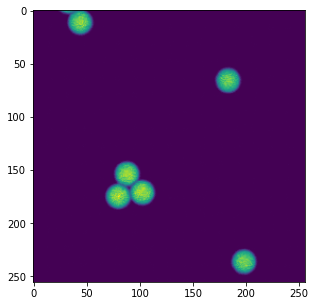

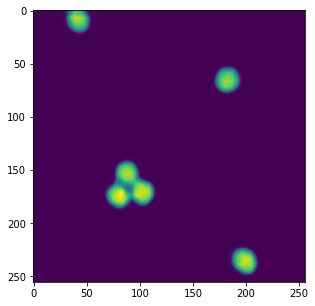

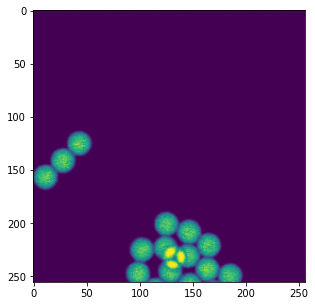

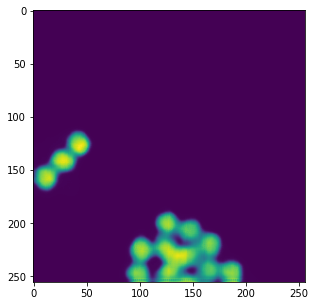

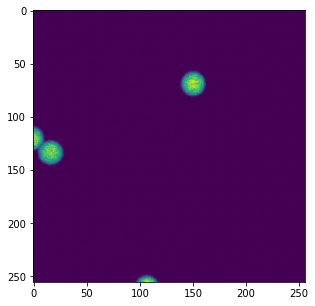

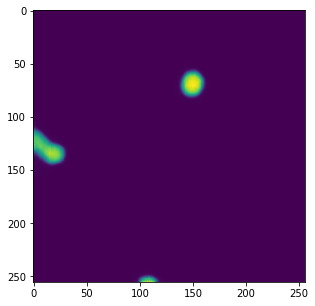

In [ ]:
encoder.save("gdrive/MyDrive/Biphoton/encoderswish_.h5")
decoder.save("gdrive/MyDrive/Biphoton/decoderswish_.h5")
for h in [h1,h2]:
  losscurve,rlosscurve,klosscurve=h.history["loss"],h.history["reconstruction_loss"],h.history["kl_loss"]
  plt.figure()
  plt.plot(losscurve)
  plt.plot(rlosscurve)
  plt.figure()
  plt.plot(klosscurve)
  plt.figure()
  plt.plot(losscurve[20:])
  plt.plot(rlosscurve[20:])
  plt.figure()
  plt.plot(klosscurve[20:])  
  plt.show()
for i in range(10):
  xpred=vae.encoder.predict(np.expand_dims(x_train[i],axis=0))
  x_pred=vae.decoder.predict(xpred[2])
  plt.figure(figsize=(5,5))
  plt.imshow(x_train[i,...,0])
  plt.figure(figsize=(5,5))
  plt.imshow(x_pred[0])

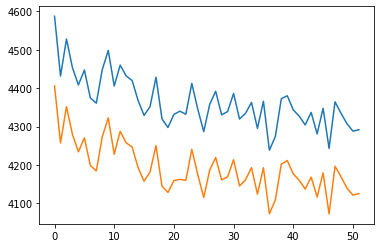

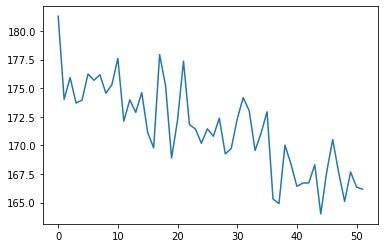

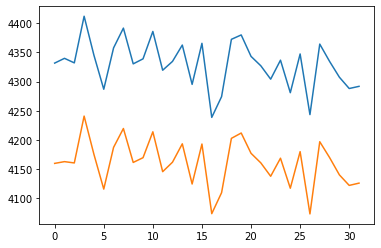

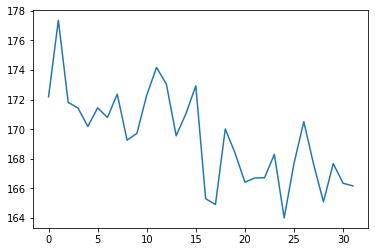

In [ ]:
for h in [h2]:
  losscurve,rlosscurve,klosscurve=h.history["loss"],h.history["reconstruction_loss"],h.history["kl_loss"]
  plt.figure()
  plt.plot(losscurve)
  plt.plot(rlosscurve)
  plt.figure()
  plt.plot(klosscurve)
  plt.figure()
  plt.plot(losscurve[20:])
  plt.plot(rlosscurve[20:])
  plt.figure()
  plt.plot(klosscurve[20:])  
  plt.show()


In [ ]:
encoder.save("gdrive/MyDrive/Biphoton/encoderswish.h5")
decoder.save("gdrive/MyDrive/Biphoton/decoderswish.h5")

In [27]:
del encoder,decoder
gc.collect()
load=False
if load:
  from tensorflow.keras.models import load_model
  encoder=load_model("/content/gdrive/MyDrive/Biphoton/encoderswish_.h5",custom_objects={
      "Sampling":Sampling})
  decoder=load_model("/content/gdrive/MyDrive/Biphoton/decoderswish_.h5")


NameError: ignored

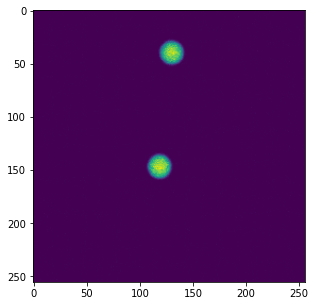

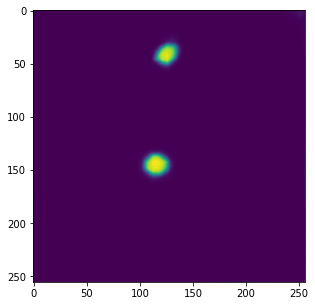

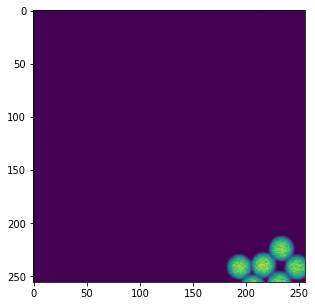

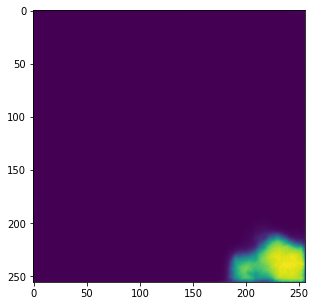

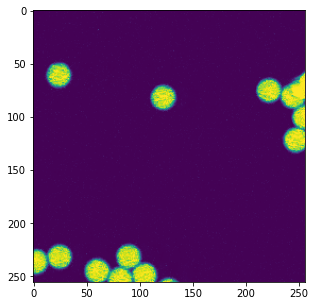

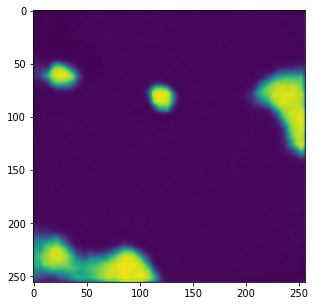

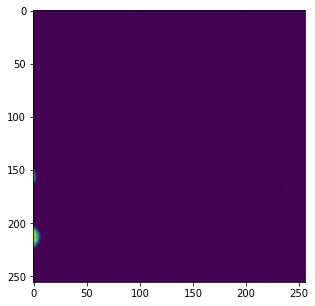

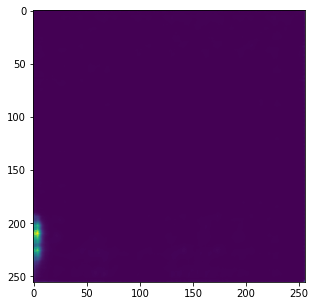

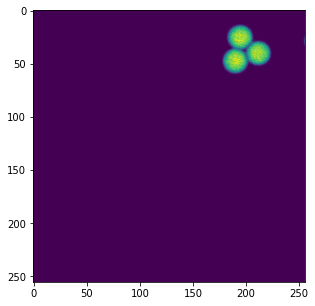

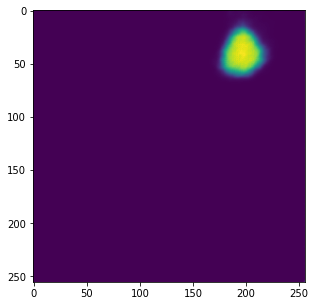

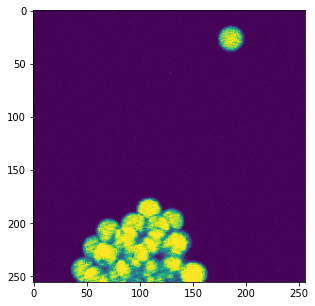

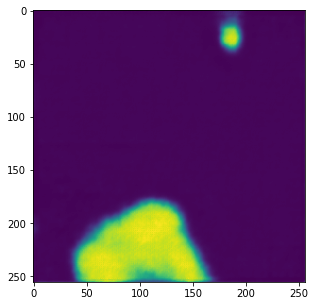

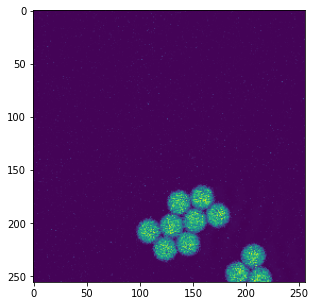

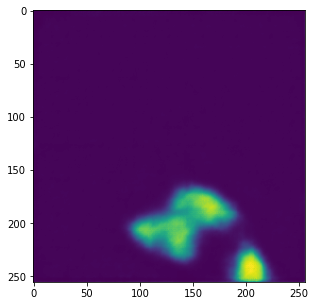

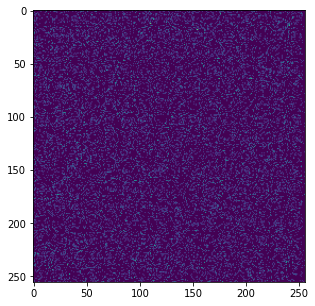

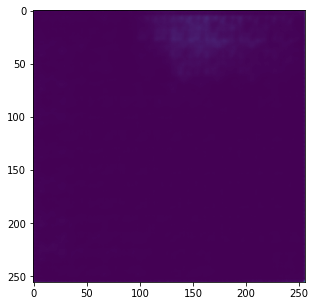

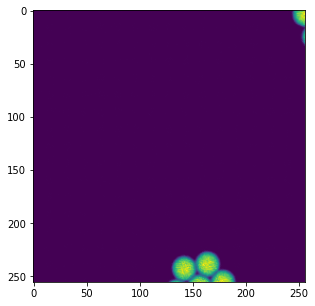

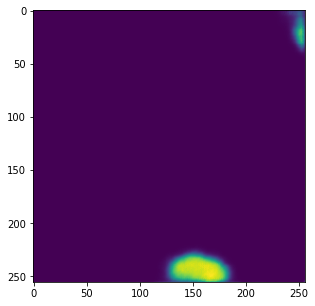

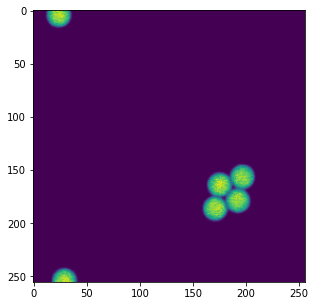

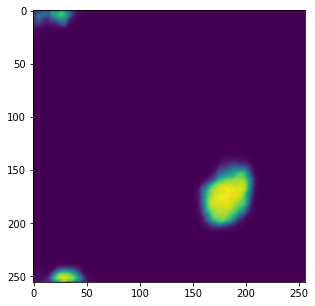

In [ ]:
for i in range(10):
  xpred=vae.encoder.predict(np.expand_dims(x_train[i],axis=0))
  x_pred=vae.decoder.predict(xpred[2])
  plt.figure(figsize=(5,5))
  plt.imshow(x_train[i,...,0])
  plt.figure(figsize=(5,5))
  plt.imshow(x_pred[0])

In [ ]:
print(np.unique(x_train))
print(np.unique(x_pred[0,...,0]))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [ ]:

def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 256
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size,2)[...,0]
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.show()


plot_latent_space(vae)

ValueError: ignored

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

11501568/11490434 [==============================] - 0s 0us/step


ValueError: ignored